In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten
import geopandas as gpd
import h5py
import boto.s3
import glob
import boto3
from zipfile import ZipFile
import shutil

In [2]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Showing the entire number in dataframe
pd.set_option('float_format', '{:f}'.format)

In [5]:
%%time
s3 = boto3.client("s3", aws_access_key_id= 'xxx',
aws_secret_access_key= 'xxx')
key = "pilates-outputs/sfbay-baseline-2022124/inexus/sfbay_baseline_default-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sfbase = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:5: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 32s
Wall time: 1min 33s


In [6]:
sfbase = sfbase[(sfbase['duration_travelling'] > 0)].reset_index(drop=True)

### We should add the INEXUS columns from the file "2_INEXUS_Calculation.ipynb" and then run the rest of the script

In [7]:
# Mapping BEAM and ActivitySim modes
conditions  = [(sfbase['mode_choice_actual_BEAM'] == 'walk')&(sfbase['trip_mode_AS_trips'] == 'WALK'),
               (sfbase['mode_choice_actual_BEAM'] == 'bike')&(sfbase['trip_mode_AS_trips'] == 'BIKE'),
               (sfbase['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sfbase['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sfbase['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sfbase['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov3')&(sfbase['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov3')&(sfbase['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sfbase['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sfbase['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sfbase['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sfbase['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov2')&(sfbase['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov2')&(sfbase['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sfbase['mode_choice_actual_BEAM'] == 'car')&(sfbase['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sfbase['mode_choice_actual_BEAM'] == 'car')&(sfbase['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK_COM'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail')&(sfbase['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail')&(sfbase['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail')&(sfbase['trip_mode_AS_trips'] == 'TAXI'),
               (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')&(sfbase['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')&(sfbase['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')&(sfbase['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')&(sfbase['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')&(sfbase['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sfbase['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sfbase['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sfbase['trip_mode_AS_trips'] == 'TAXI'),
       
               (sfbase['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sfbase['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sfbase['trip_mode_AS_trips'] == 'SHARED3PAY')|(sfbase['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov2')&((sfbase['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sfbase['trip_mode_AS_trips'] == 'SHARED3FREE')|(sfbase['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov3')&((sfbase['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sfbase['trip_mode_AS_trips'] == 'SHARED2FREE')|(sfbase['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sfbase['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sfbase['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sfbase['trip_mode_AS_trips'] == 'SHARED2PAY')|(sfbase['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sfbase['mode_choice_actual_BEAM'] == 'car')&((sfbase['trip_mode_AS_trips'] == 'SHARED3FREE')|(sfbase['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sfbase['trip_mode_AS_trips'] == 'SHARED3PAY')|(sfbase['trip_mode_AS_trips'] == 'SHARED2PAY')|(sfbase['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sfbase['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sfbase['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sfbase['mode_choice_actual_BEAM'] == 'walk')&((sfbase['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sfbase['trip_mode_AS_trips'] == 'WALK_LOC')|(sfbase['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sfbase['trip_mode_AS_trips'] == 'WALK_HVY')|(sfbase['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK'),
               
               ((sfbase['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sfbase['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sfbase['trip_mode_AS_trips'] == 'TAXI')|(sfbase['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sfbase['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sfbase['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sfbase['trip_mode_AS_trips'] == 'WALK_LOC')|(sfbase['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sfbase['trip_mode_AS_trips'] == 'WALK_HVY')|(sfbase['trip_mode_AS_trips'] == 'WALK_COM')|
               (sfbase['trip_mode_AS_trips'] == 'WALK'))),
               
               (sfbase['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sfbase['mode_choice_actual_BEAM'] == 'car')&((sfbase['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sfbase['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sfbase['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sfbase['WALK'], sfbase['BIKE'], sfbase['SHARED3FREE'], sfbase['SHARED3PAY'],
           sfbase['SHARED3FREE'], sfbase['SHARED3PAY'], sfbase['SHARED2FREE'], 
           sfbase['SHARED2PAY'], sfbase['SHARED2PAY'], sfbase['SHARED2FREE'], 
           sfbase['DRIVEALONEFREE'], sfbase['DRIVEALONEPAY'], sfbase['WALK_LRF'], 
           sfbase['WALK_LOC'], sfbase['WALK_EXP'], sfbase['WALK_HVY'], sfbase['WALK_COM'],
           sfbase['TNC_SINGLE'], 
           sfbase['TNC_SHARED'], sfbase['TAXI'],
           sfbase['DRIVE_COM'], sfbase['DRIVE_LRF'], sfbase['DRIVE_LOC'], sfbase['DRIVE_EXP'],
           sfbase['DRIVE_HVY'], sfbase['TNC_SINGLE'], sfbase['TNC_SHARED'], sfbase['TAXI'],
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sfbase[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sfbase[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sfbase[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [8]:
sfbase['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [9]:
sfbase['Realized_INEXUS'] = np.where((sfbase['Realized_INEXUS'].isna())&((sfbase['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sfbase['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sfbase['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sfbase['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sfbase['mode_choice_actual_BEAM'] == 'car')|
                                          (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sfbase['Realized_INEXUS'])

In [11]:
sfbase['Realized_INEXUS'] = np.where((sfbase['Realized_INEXUS'].isna())&((sfbase['mode_choice_actual_BEAM'] == 'walk')|
                                         (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                          sfbase[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sfbase['Realized_INEXUS'])

In [12]:
sfbase['Realized_INEXUS'] = np.where(sfbase['Realized_INEXUS'].isna()&(sfbase['mode_choice_actual_BEAM'] == 'bike'), 
                                         sfbase[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sfbase['Realized_INEXUS'])

In [13]:
# dropping the rows with NAN utility values
sfbase.dropna(subset=['Realized_INEXUS'], inplace=True)

In [14]:
# Function to calculate c_ivt based on primary_purpose
def calculate_in_vehicle_time_coefficient(primary_purpose):
    conditions = [
        (primary_purpose == 'work'),
        (primary_purpose == 'univ'),
        (primary_purpose == 'school'),
        (primary_purpose == 'escort'),
        (primary_purpose == 'shopping'),
        (primary_purpose == 'eatout'),
        (primary_purpose == 'othmaint'),
        (primary_purpose == 'social'),
        (primary_purpose == 'othdiscr'),
        (primary_purpose == 'atwork')
    ]
    
    choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]
    
    return np.select(conditions, choices, default=np.nan)

In [16]:
# Calculate c_ivt and assign it to 'c_ivt' column
sfbase['c_ivt'] = calculate_in_vehicle_time_coefficient(sfbase['primary_purpose_x'])

In [17]:
# Calculate alpha based on 'c_ivt' and 'value_of_time'
sfbase['alpha'] = -0.6 * (sfbase['c_ivt']) / (sfbase['value_of_time'])

In [18]:
# Calculate the Realized INEXUS in_dollar - Multiply by 1.75 to convert it to the 2023 dollar value
sfbase['Realized_INEXUS_in_dollar_2023'] = ((sfbase['Realized_INEXUS'] / sfbase['alpha']) / 100) * 1.75

In [19]:
# Calculate the Potential INEXUS in dollar - Multiply by 1.75 to convert it to the 2023 dollar value 
sfbase['Potential_INEXUS_in_dollar_2023'] = ((sfbase['logsum_trip_Potential_INEXUS'] / sfbase['alpha']) / 100) * 1.75

### We used the Isolation Forest method to remove the outliers 

In [20]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sfbase[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values # We may consider adding 'duration_walking'

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sfbase['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sfbase_clean_ml = sfbase[sfbase['is_outlier'] == 1]

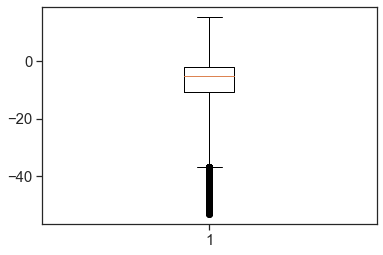

In [21]:
plt.boxplot(sfbase_clean_ml['Realized_INEXUS_in_dollar_2023'], whis=3)
plt.show()

In [22]:
sfbase_clean_ml = sfbase_clean_ml[(sfbase_clean_ml['duration_walking'] < 3600)&(sfbase_clean_ml['distance_walking'] < 5000)]

### Baseline INEXUS plots (ridehail price scenario)

#### Simple Potential INEXUS

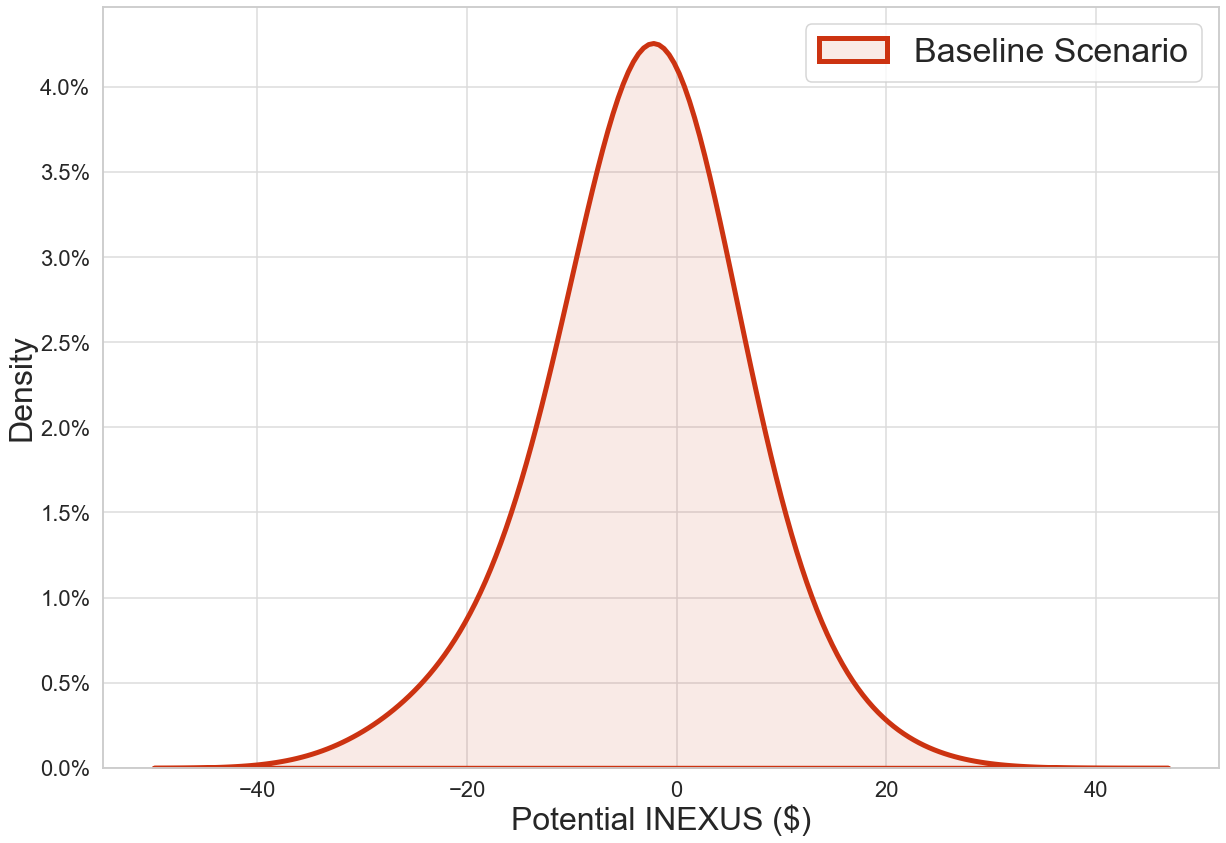

In [24]:
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid",{'grid.color': 'gainsboro'}) 
#'whitesmoke': a very light grey color with a hint of blue.
#'gainsboro': a very light grey color with a hint of blue-green.
#'lightgray': a slightly lighter shade of grey than 'lightgrey'.
#'lavender'

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

ax=sns.kdeplot(data=sfbase_clean_ml, x="Potential_INEXUS_in_dollar_2023", 
            fill=True, alpha=0.1, color="#CC3311", bw_adjust =15, linewidth =5)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)
plt.legend(labels = ['Baseline Scenario'],
          fontsize='small', fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

#plt.xlim(-80, 70)
plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Baseline Scenario'], loc="best", fontsize=34),), bbox_inches='tight')
plt.savefig('density_baseline.png', bbox_extra_artists=(ax.legend(['Baseline Scenario'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 300)

#### Mode split Potential INEXUS

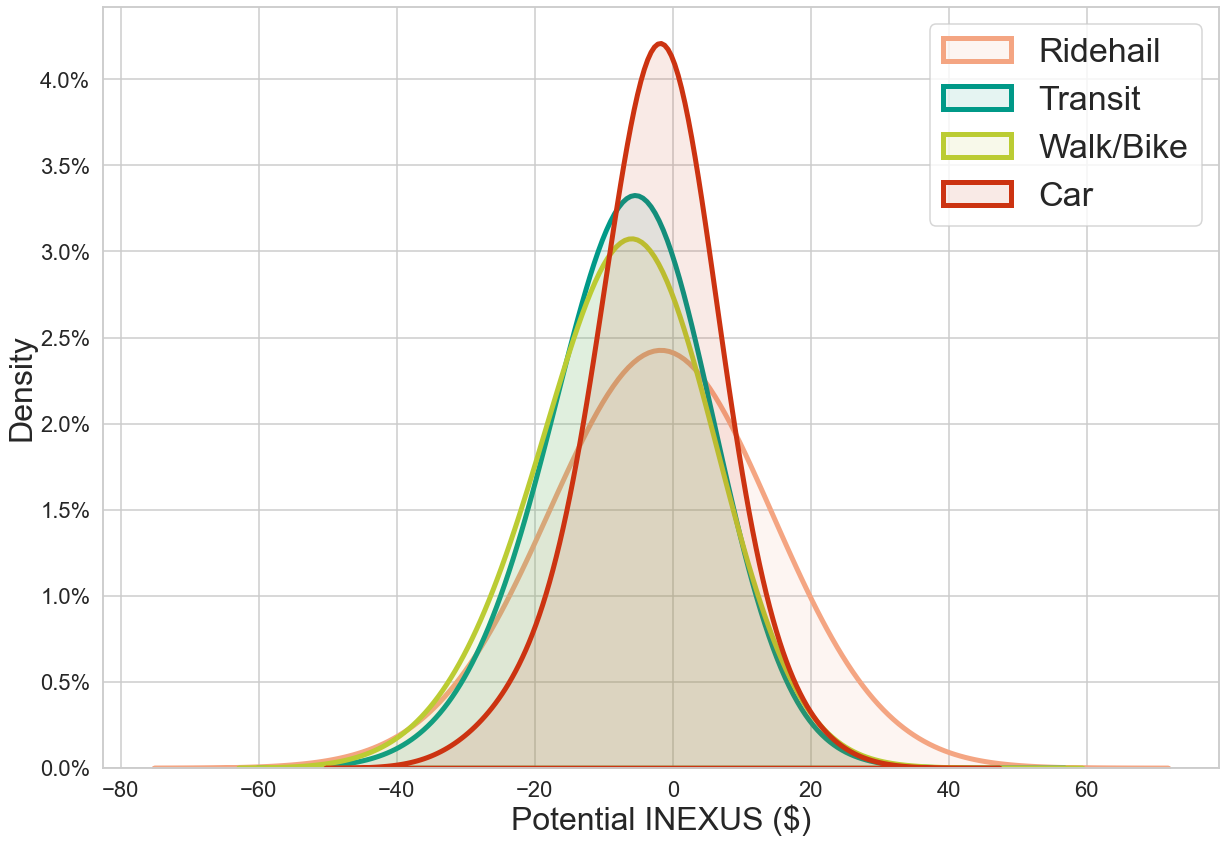

In [25]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
color_dict = {'walk/bike': '#CC3311', 'car': '#BBCC33', 'transit': '#009988', 'ride_hail': '#F4A582'} 

ax=sns.kdeplot(data=sfbase_clean_ml, x="Potential_INEXUS_in_dollar_2023", hue = 'mode_choice_actual_4', 
            fill=True, common_norm=False, common_grid = False, palette=color_dict.values(), alpha=0.1, bw_adjust =15, linewidth =5)  #color_dict.values()
#sns.color_palette('rocket_r', n_colors=4) #palette=color_dict.values()
#rainbow_r  tab20
#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

#plt.xlim(-130, 130)

plt.legend(labels = ['Ridehail', 'Transit', 'Walk/Bike', 'Car'],
          fontsize='small', fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_mode_baseline.svg', bbox_extra_artists=(ax.legend( ['Ridehail', 'Transit', 'Walk/Bike', 'Car'], loc="best", fontsize=34),), bbox_inches='tight')
plt.savefig('density_mode_baseline.png', bbox_extra_artists=(ax.legend( ['Ridehail', 'Transit', 'Walk/Bike', 'Car'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 300)

#### Mandatory - Non-mandatory categories

In [26]:
# Add the mandatory category column
mandatory = ['work' , 'univ', 'school']
sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType.isin(mandatory)) & (sfbase_clean_ml.actStartType.isin(mandatory)), 'from_M_to_M' , None)

In [27]:
sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType == 'Home') & (sfbase_clean_ml.actStartType.isin(mandatory)), 'from_H_to_M' , sfbase_clean_ml['mandatoryCat'])

In [28]:
sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType.isin(mandatory)) & (sfbase_clean_ml.actStartType == "Home"), 'from_M_to_H' , sfbase_clean_ml['mandatoryCat'])

In [31]:
non_mandatory = ['othmaint' , 'othdiscr', 'escort', 'eatout', 'social', 'shopping', 'atwork']
sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType.isin(non_mandatory)) & (sfbase_clean_ml.actStartType.isin(non_mandatory)), 'from_N_to_N' , sfbase_clean_ml['mandatoryCat'])

In [32]:
sfbase_clean_ml['mand_cat'] = np.where(sfbase_clean_ml['mandatoryCat'].isin(['from_M_to_M', 'from_M_to_H', 'from_H_to_M']), 'mand', 'non-mand')

In [33]:
sfbase_clean_ml.groupby('mand_cat')['Potential_INEXUS_in_dollar_2023'].describe()

,count,mean,std,min,25%,50%,75%,max
mand_cat,,,,,,,,
mand,657480.000000,-7.198015,7.584629,-30.380955,-11.215310,-5.587904,-2.167129,27.386846
non-mand,1490788.000000,-1.381593,7.528667,-30.380765,-4.510210,-1.187926,2.217558,27.229892


C:\Users\nrezaei\anaconda3\envs\BEAM-CORE\lib\site-packages\seaborn\utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


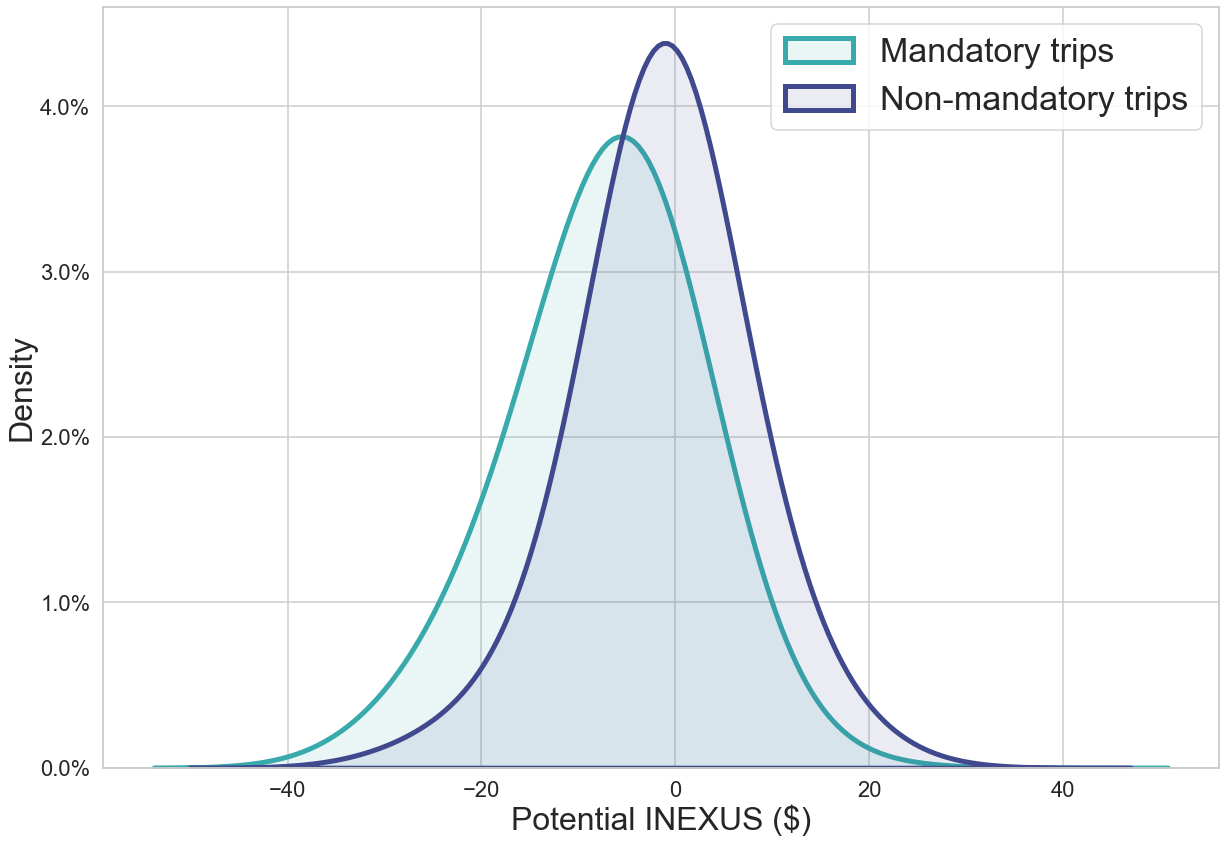

In [34]:
sns.set(rc={'figure.figsize':(20,14)}) #
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})

ax=sns.kdeplot(data=sfbase_clean_ml, x="Potential_INEXUS_in_dollar_2023", hue = 'mand_cat',
            fill=True, common_norm=False, alpha=0.1, palette=sns.color_palette('mako', n_colors=2), bw_adjust =15, linewidth =5)
sns.move_legend(ax, labels = ['Mandatory trips','Non-mandatory trips'], loc="best", ncol=1, title=None, frameon=True, fontsize = 28)#, bbox_to_anchor=(1.25, 0.6), 

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

#plt.xlim(-90, 75)
plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_mand_baseline.svg', bbox_extra_artists=(ax.legend(['Mandatory trips','Non-mandatory trips'], loc="best", fontsize=28),), bbox_inches='tight')
plt.savefig('density_mand_baseline.png', bbox_extra_artists=(ax.legend(['Mandatory trips','Non-mandatory trips'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 300)

#### Distance INEXUS plot

In [35]:
# get the quartiles of the distance column
quartiles = np.percentile(sfbase_clean_ml['distance_travelling'], [25, 50, 75])

# set the cutoffs based on the quartiles
cutoffs = [0, quartiles[0], quartiles[1], quartiles[2], float('inf')]

# label the distances based on the cutoffs
sfbase_clean_ml['distance_group'] = pd.qcut(sfbase_clean_ml['distance_travelling'], q=3, labels=['short', 'medium', 'long'])

In [36]:
# Add a column of income deciles
deciles = sfbase_clean_ml['distance_travelling'].quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()

In [37]:
# Add distance_travelling deciles
conditions  = [(sfbase_clean_ml['distance_travelling'] >= deciles[0]) & (sfbase_clean_ml['distance_travelling'] < deciles[1]), 
               (sfbase_clean_ml['distance_travelling'] >= deciles[1]) & (sfbase_clean_ml['distance_travelling'] < deciles[2]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[2]) & (sfbase_clean_ml['distance_travelling'] < deciles[3]),
               (sfbase_clean_ml['distance_travelling'] >= deciles[3]) & (sfbase_clean_ml['distance_travelling'] < deciles[4]), 
               (sfbase_clean_ml['distance_travelling'] >=  deciles[4]) & (sfbase_clean_ml['distance_travelling'] < deciles[5]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[5]) & (sfbase_clean_ml['distance_travelling'] < deciles[6]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[6]) & (sfbase_clean_ml['distance_travelling'] < deciles[7]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[7]) & (sfbase_clean_ml['distance_travelling'] < deciles[8]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[8]) & (sfbase_clean_ml['distance_travelling'] < deciles[9]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[9]) & (sfbase_clean_ml['distance_travelling'] <= deciles[10])]

choices = [ '1stD', '2ndD', '3rdD', 
           '4thD', '5thD', '6thD', '7thD', '8thD', '9thD','10thD']

In [38]:
sfbase_clean_ml['distance_deciles'] = np.select(conditions, choices, default=None)

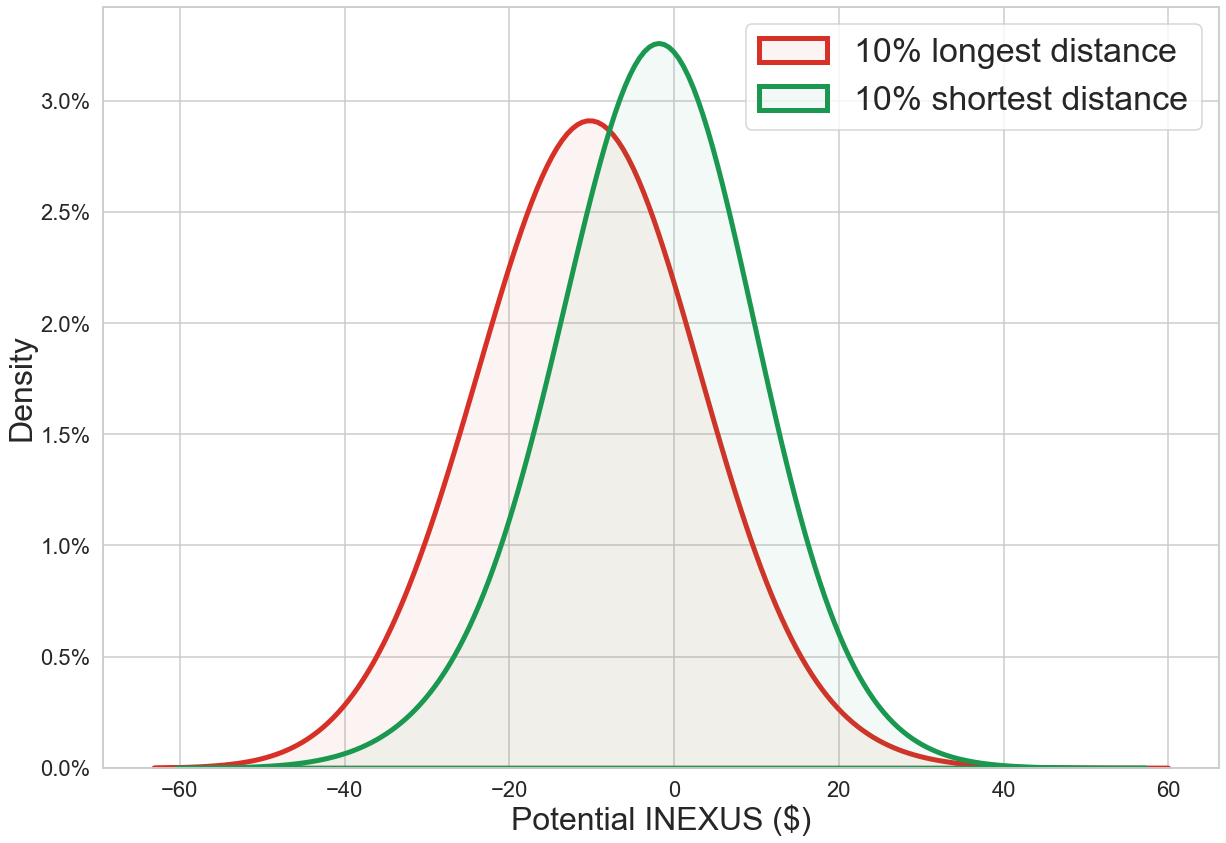

In [39]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
colors = ["#1a9850", "#d73027", "#FFA07A", "#b3de69"] 

#color_dict = {'walk/bike': '#CC3311', 'car': '#BBCC33', 'transit': '#009988', 'ride_hail': '#F4A582'} 
sns.set_palette(sns.color_palette(colors))

ax=sns.kdeplot(data=sfbase_clean_ml[(sfbase_clean_ml['distance_deciles'] == '1stD')|(sfbase_clean_ml['distance_deciles'] == '10thD')]
                                    , x="Potential_INEXUS_in_dollar_2023", hue = 'distance_deciles', 
            fill=True, common_norm=False, common_grid = False,alpha=0.05, bw_adjust =15, linewidth =5)  #color_dict.values()
#sns.color_palette('rocket_r', n_colors=4) #palette=color_dict.values()
#rainbow_r  tab20
#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

#plt.xlim(-120, 100)

plt.legend(labels = ['10% longest distance','10% shortest distance'],
        fontsize='small', title_fontsize = 30, fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_baseline_distance.svg', bbox_extra_artists=(ax.legend(['10% longest distance','10% shortest distance'], loc="best", fontsize=34),), bbox_inches='tight')
plt.savefig('density_baseline_distance.png', bbox_extra_artists=(ax.legend(['10% longest distance','10% shortest distance'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 300)

### IQR (an alternative way to remove the outliers that we didn't use)

In [ ]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sfbase['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sfbase['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
sfbase_clean_iqr = sfbase[(sfbase['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sfbase['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sfbase['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sfbase['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]